# Labs : Logistic Regression, LDA, QDA and KNN 

This is the chapter $4$ lab we will examine the **Smarket** data part of the book's li

In [20]:
import numpy as np
import pandas as pd 
from matplotlib.pyplot import subplots 
import statsmodels.api as sm 

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

In [21]:
from ISLP import confusion_table
from ISLP.models import contrast

from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Exploring Data

In [22]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [23]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

- We cant compute the correlation between the features since the **Direction** is a qualitative value

In [24]:
#Smarket.corr()

In [25]:
Smarket.Volume

0       1.19130
1       1.29650
2       1.41120
3       1.27600
4       1.20570
         ...   
1245    1.88850
1246    1.28581
1247    1.54047
1248    1.42236
1249    1.38254
Name: Volume, Length: 1250, dtype: float64

<Axes: >

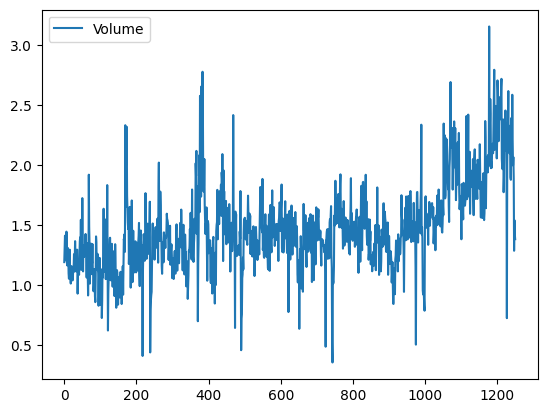

In [26]:
Smarket.plot(y='Volume')

## Logistic Regression 

- Fitting Logistic Regression model to predict **Direction**, which we need to drop the **Year, Direction, Today** Columns  since they are redundant and not important 

In [27]:
allvars = Smarket.columns.drop(['Today','Direction','Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm= sm.GLM(y,X,family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [28]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [29]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

- The `predict()` method returns predictions on the probability when no arguments provided it used the **Training** data to compute the probabilities
- We set the threshold to $50\%$ in `labels`

In [30]:
probs = results.predict()
probs.size

1250

In [31]:
labels = np.array(['Down']*1250)
labels[probs>0.5]='Up'
labels

array(['Up', 'Down', 'Down', ..., 'Up', 'Up', 'Up'], dtype='<U4')

In [32]:
confusion_table(labels,Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [33]:
np.mean(labels== Smarket.Direction)

0.5216

- Which indicate that our **Logistic Regression** model predicts correctly the market $52\%$
- means that the **Train Error** is $47.8\%$, which usually is low and underestimate the **Test Error**
- Applying the **CV-Holdout**, we hold out the observations from the year $2005$ and train the model on the years from $2001$ to $2004$

In [34]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test =Smarket.loc[~train]
Smarket_test.shape
print(Smarket_test)
print(Smarket_train)

      Year   Lag1   Lag2   Lag3   Lag4   Lag5   Volume  Today Direction
998   2005 -0.134  0.008 -0.007  0.715 -0.431  0.78690 -0.812      Down
999   2005 -0.812 -0.134  0.008 -0.007  0.715  1.51080 -1.167      Down
1000  2005 -1.167 -0.812 -0.134  0.008 -0.007  1.72100 -0.363      Down
1001  2005 -0.363 -1.167 -0.812 -0.134  0.008  1.73890  0.351        Up
1002  2005  0.351 -0.363 -1.167 -0.812 -0.134  1.56910 -0.143      Down
...    ...    ...    ...    ...    ...    ...      ...    ...       ...
1245  2005  0.422  0.252 -0.024 -0.584 -0.285  1.88850  0.043        Up
1246  2005  0.043  0.422  0.252 -0.024 -0.584  1.28581 -0.955      Down
1247  2005 -0.955  0.043  0.422  0.252 -0.024  1.54047  0.130        Up
1248  2005  0.130 -0.955  0.043  0.422  0.252  1.42236 -0.298      Down
1249  2005 -0.298  0.130 -0.955  0.043  0.422  1.38254 -0.489      Down

[252 rows x 9 columns]
     Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
0    2001  0.381 -0.192 -2.624 -1.055  5.0

In [35]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

glm_train = sm.GLM(y_train,X_train,family=sm.families.Binomial())

results = glm_train.fit()

probs = results.predict(exog=X_test)
probs

998     0.528220
999     0.515669
1000    0.522652
1001    0.513854
1002    0.498334
          ...   
1245    0.483637
1246    0.506048
1247    0.516658
1248    0.516124
1249    0.508072
Length: 252, dtype: float64

- In this example the model is trained and tested on two completely seprate data sets which gives accurate measures to the model performance 

In [36]:
D = Smarket.Direction
D

0         Up
1         Up
2       Down
3         Up
4         Up
        ... 
1245      Up
1246    Down
1247      Up
1248    Down
1249    Down
Name: Direction, Length: 1250, dtype: category
Categories (2, object): ['Down', 'Up']

In [37]:
L_train, L_test = D.loc[train], D[~train]

In [38]:
labels =np.array(['Down']*252)
labels[probs>0.5]='Up'
confusion_table(labels,L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


- Showing that the **Logistic Regression** predicted $121$ observation correct and $131$ case wrong which is $52\%$
- Which is expected since its very unlikely to predict market based on past results 

In [39]:
model = MS(['Lag1','Lag2']).fit(Smarket)
# Fitting the mode using onl the two predictors with the highest p-values 
X = model.transform(Smarket) 
X_train, X_test = X.loc[train], X.loc[~train]

glm_train = sm.GLM(y_train,X_train, family= sm.families.Binomial())
results = glm_train.fit()

probs = results.predict(exog=X_test)

labels=np.array(['Down']*252)
labels[probs>0.5]= 'Up'

confusion_table(labels,L_test)


Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


- This **Logistic Regression** model was only fitted using the predictors with the highest `p_value` the **Lag1, Lag2**
- The new prediction results are improved in total $141$ are predicted correctly 

In [40]:
(35+106)/252,(106/(106+76))

(0.5595238095238095, 0.5824175824175825)

- Which improves the model now it predicts $56\%$ correctly
- The **Test Error** is no still high and no better than the naive approach
- But when it comes to **Up** the logistic regression model predicts $58\%$ correct, Which suggests when the model predicts an increase better avoid trading 

In [41]:
single_newdata  = pd.DataFrame({'Lag1':[1.2,1.5],'Lag2':[1.1,-0.8]})

newX= model.transform(single_newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

- Here we making a prediction on  a day where the `Lag1` and `Lag2` values are set
- Using the predict function gives 

## Linear Discriminant Analysis

Now performing **LDA** on the Smarket data  

In [42]:
lda = LDA(store_covariance=True)

X_train , X_test =[M.drop(columns=['intercept'],errors='ignore') 
                   for M in [X_train,X_test]]
lda.fit(X_train,L_train)
X_train

,Lag1,Lag2
0,0.381,-0.192
1,0.959,0.381
2,1.032,0.959
3,-0.623,1.032
4,0.614,-0.623
...,...,...
993,0.046,0.342
994,-0.431,0.046
995,0.715,-0.431
996,-0.007,0.715


In [43]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

- Prior values $f_{k}(x)$ for the two classes
- `Down`,`Up` are the classes that the LDA wanna classify

In [44]:
lda.priors_ 

array([0.49198397, 0.50801603])

In [45]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [46]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [47]:
lda_pred =lda.predict(X_test)
lda_pred

array(['Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down',
       'Down', 'Down', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down',
       'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Down', 'Up',
       'Up', 'Up', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down',
       'Down', 'Up', 'Up', 'Down', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Down', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Down', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Down', 'Down', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Down', 'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Down', 'Down', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down',
       'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 

In [48]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [49]:
lda_probs = lda.predict_proba(X_test)
np.all(np.where(lda_probs[:,1]>=0.5,'Up','Down')==lda_pred)

True

In [50]:
np.all([lda.classes_[i] for i in np.argmax(lda_probs,1)]== lda_pred)

True

- each row on the `lda_probs` represents sample and each **column** represents a class  
- This makes us able to change treshold to suit better problems 

In [51]:
np.sum(lda_probs[:,0]>0.52)

1

## Quadratic Discriminant Analysis

In [52]:
qda = QDA(store_covariance=True)
qda.fit(X_train,L_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [53]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [54]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [55]:
qda.covariance_[1]

array([[ 1.51700576, -0.02787349],
       [-0.02787349,  1.49026815]])

In [65]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


- The `predict` method calculate the discriminant fucntion $\delta_{k}$ for each class and assign it to the class $k$ with the largest discriminant function
- **QDA** predicts $151$ results  correctly and $101$ missclassified
- **QDA** performed better than the **LDA** with $60\%$ accuracy

In [67]:
(151)/252

0.5992063492063492

In [68]:
np.mean(qda_pred == L_test)

0.5992063492063492

- The **QDA** beats the **LDA** and **Logistic Regression**
- But it's need more evaluation on bigger test data set

## Naive Bayes

In [71]:
NB = GaussianNB()
NB.fit(X_train, L_train)

,priors,None
,var_smoothing,1e-09


In [72]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [73]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [74]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [75]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [76]:
NB?

Type:        GaussianNB
String form: GaussianNB()
File:        ~/isl-python/.venv/lib/python3.12/site-packages/sklearn/naive_bayes.py
Docstring:  
Gaussian Naive Bayes (GaussianNB).

Can perform online updates to model parameters via :meth:`partial_fit`.
For details on algorithm used to update feature means and variance online,
see `Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque
<http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf>`_.

Read more in the :ref:`User Guide <gaussian_naive_bayes>`.

Parameters
----------
priors : array-like of shape (n_classes,), default=None
    Prior probabilities of the classes. If specified, the priors are not
    adjusted according to the data.

var_smoothing : float, default=1e-9
    Portion of the largest variance of all features that is added to
    variances for calculation stability.

    .. versionadded:: 0.20

Attributes
----------
class_count_ : ndarray of shape (n_classes,)
    number of training samples ob

In [79]:
X_train[L_train=='Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [82]:
X_train[L_train=='Up'].mean()

Lag1   -0.039546
Lag2   -0.031325
dtype: float64

In [80]:
X_train[L_train=='Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [81]:
X_train[L_train=='Up'].var(ddof=0)

Lag1    1.514014
Lag2    1.487329
dtype: float64

In [84]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels,L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


- The Gaussian Naive Bayse results in $150$ correct prediction
- Which is around $59\%$
- Better than the **LDA** and slightly worse than **QDA**

In [87]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

## K-Nearest Neighbors 

- Now applying the non-parametric approach **K-Nearest Neighbors**, the fitting process is the same as **LDA** **QDA** 

In [96]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train,L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


- As expected the  **KNN** with $K=1$ results in very poor predictions
- Predcited $126$ correctly around $50\%$

In [97]:
(43+83)/252 , np.mean(knn1_pred==L_test)

(0.5, 0.5)

In [99]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train,L_train)
knn3_pred = knn3.predict(X_test)
confusion_table(knn3_pred, L_test)

Truth,Down,Up
Predicted,,
Down,48,55
Up,63,86


In [100]:
np.mean(knn3_pred==L_test)

0.5317460317460317

- The **KNN** algorithm isnt suited and doesn't perform well on the **Smarket** data
- Loading the **Caravan** data from the book library 

In [101]:
Caravan = load_data('Caravan')
Caravan

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,No
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,Yes
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,No


In [103]:
Purchase = Caravan.Purchase
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [105]:
len(Purchase)

5822

In [108]:
feature_df = Caravan.drop(columns=['Purchase'])
feature_df

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,2,0,0,0,1,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,0,1,0,0,0,0,0
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


- Since **KNN** classifer measures the distance between observations
- Differences between the data nature(Money and age for example)
- **Feature scaling** methods : Normalization and Standardization
- In this case **Standardization** is used transforming the observations to have a **mean** of $0$ and std of $1$

In [111]:
scaler = StandardScaler(with_mean=True,with_std=True,copy=True)
scaler

,copy,True
,with_mean,True
,with_std,True


In [114]:
scaler.fit(feature_df)
x_std = scaler.transform(feature_df)
x_std

array([[ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.99229684, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.99229684, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647],
       ...,
       [ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.75875388, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647]])

In [117]:
feature_std = pd.DataFrame(x_std,columns=feature_df.columns)
feature_std

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,0.680906,-0.27258,0.406697,-1.216964,0.779405,-0.694311,0.217444,-0.068711,-0.161816,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
1,0.992297,-0.27258,-0.859500,-1.216964,0.779405,0.302552,-0.365410,-0.068711,0.464159,-0.096077,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
2,0.992297,-0.27258,-0.859500,-1.216964,0.779405,-0.694311,-0.365410,0.914172,0.464159,-1.667319,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
3,-1.187437,-0.27258,0.406697,0.010755,-0.970980,1.299414,-0.948264,0.914172,0.464159,-0.619824,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
4,1.225840,-0.27258,1.672893,-1.216964,1.479559,0.302552,-0.365410,-0.068711,0.464159,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,0.914449,-0.27258,-2.125697,-1.216964,0.779405,-0.694311,0.800298,-0.068711,-0.787790,-2.714813,...,5.094585,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5818,0.836602,-0.27258,1.672893,1.238473,0.779405,0.302552,-0.365410,-0.068711,0.464159,-0.096077,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5819,0.680906,-0.27258,0.406697,1.238473,0.779405,-0.694311,0.800298,-1.051594,-0.161816,-0.619824,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5820,0.758754,-0.27258,0.406697,-1.216964,0.779405,-0.694311,1.383152,-1.051594,-0.787790,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816


In [118]:
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [119]:
(X_train,X_test,y_train,y_test) = train_test_split(feature_std,Purchase,test_size=1000,random_state=0)

In [122]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train,y_train).predict(X_test)
np.mean(y_test != knn1_pred),np.mean(y_test !="No"),np.mean(y_test==knn1_pred)

(0.111, 0.067, 0.889)

In [123]:
confusion_table(knn1_pred,y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [124]:
9/(53+9)

0.14516129032258066

- The error rate is $14\%$ which is better than randomly guessing
- If we randomly guessed that every case is a **No** it will result in $6\%$


### Tunning Parameters

In [131]:
for K in range (1,8):
    knn =KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train,y_train).predict(X_test)
    C = confusion_table(knn_pred,y_test)
    tmpl =('K={0:d}:# predicted to rent : {1:>2},'+"# Who did rent {2:d}. accuracy {3: .1%}")
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(tmpl.format(K,pred,did_rent,did_rent/pred))

K=1:# predicted to rent : 62,# Who did rent 9. accuracy  14.5%
K=2:# predicted to rent :  6,# Who did rent 1. accuracy  16.7%
K=3:# predicted to rent : 20,# Who did rent 3. accuracy  15.0%
K=4:# predicted to rent :  4,# Who did rent 0. accuracy  0.0%
K=5:# predicted to rent :  7,# Who did rent 1. accuracy  14.3%
K=6:# predicted to rent :  4,# Who did rent 0. accuracy  0.0%
K=7:# predicted to rent :  5,# Who did rent 1. accuracy  20.0%


In [140]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train,y_train)
logit_pred = logit.predict_proba(X_test)

logit_labels =np.where(logit_pred[:,0]>5, 'Yes','No')

confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,933,67
Yes,0,0


In [141]:
logit_labels =np.where(logit_pred[:,1]>0.25, "Yes", "No")

confusion_table(logit_labels,y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [142]:
9/(20+9)

0.3103448275862069

- The logistc regression performs better than randomly guessing
- About $31\%$ correct predictions 

## Linear and Piosson Regression Bikeshare Data